# Replica project

### Clustering efforts



In [2]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
import sys
from glob import glob


sys.path.insert(0, "../model/")
from utils import *

sys.path.insert(0, "../web_annotation/")
from utils_clusters import *
from metrics_clusters import * 


data_dir = '/scratch/students/schaerf/'
data_dir = '../data/'

### Making the clusters

In [2]:
type_clustering = input() #'dbscan'

In [3]:
subfolder_dir = input() #'25-05-2022'

In [27]:
if type_clustering in ['dbscan', 'optics']:
    dist = float(input()) #1200
else:
    dist = int(input()) #1200

In [26]:
dist2 = float(input()) #0.12

In [3]:
effort = int(input()) #0,1,2

In [4]:
if effort == 0:
    data_file = 'data_sample.csv'
elif effort == 3:
    data_file = 'data.csv'
else:
    data_file = subfolder_dir + '/data_retrain_'+str(effort)+'.csv'


In [ ]:
embeds_file = subfolder_dir + '/resnext-101_'+subfolder_dir+'.npy'
map_file = subfolder_dir + '/map2pos.pkl'
cluster_file = subfolder_dir + '/clusters_'+type_clustering+'_'+str(dist)+'_'+subfolder_dir+'_19.pkl'

In [29]:
cluster_file

'01-06-2022/clusters_dbscan_kmeans_500_01-06-2022_19.pkl'

In [30]:
clusters = make_clusters_embeddings(data_dir, dist=dist, data_file=data_file, embed_file=embeds_file, type_clustering=type_clustering, dist2=dist2)

(9069, 2)
(8958, 2)
-1      6028
 1      1355
 24       33
 138      19
 12       16
        ... 
 243       2
 241       2
 240       2
 239       2
 508       2
Name: cluster, Length: 510, dtype: int64 510
1
1355
[ 90 191 199 ... 142 150  43]
(8958, 2)
stats
-1      6028
 24       33
 138      19
 12       16
 9        15
        ... 
 525       1
 533       1
 743       1
 932       1
 811       1
Name: cluster, Length: 1009, dtype: int64 1009
(8958, 3)


In [31]:
with open(data_dir + cluster_file, 'wb') as outfile:
    pickle.dump(clusters, outfile)

In [5]:
metadata = pd.read_csv(data_dir + data_file)#.drop(columns=['level_0'])# 'data_sample.csv')
positives = update_morph(data_dir, '') 

before adding the new ones (6293, 6)
after adding (7458, 6)
after deduplicating (6713, 6)
(60608, 24) (51569, 24)
(4700, 24) (3967, 24)
(8667, 26)


In [33]:
cluster_morph_scores = evaluate_morph(positives, cluster_file, set_splits = ['test', 'val'])
cluster_morph_scores

dict_values(['01-06-2022/clusters_dbscan_kmeans_500_01-06-2022_19.pkl', 1007, 2928, 0.78, 0.18])

### Getting 2d position for visual clustering

In [55]:
map2pos = get_2d_pos(data_dir, embed_file=embeds_file)
with open(data_dir + map_file, 'wb') as outfile:
    pickle.dump(map2pos, outfile)

### Retraining

Annotation based scores

In [26]:
for subfolder_dir in ['25-05-2022', '28-05-2022', '01-06-2022']:
    
    positives = update_morph(data_dir, subfolder_dir)
    novelty_scores = novelty_score(positives, subfolder_dir)
    print(subfolder_dir, novelty_scores)

    morpho_graph_clusters = pd.read_csv(data_dir + 'morphograph_clusters.csv')
    morpho_graph_clusters = morpho_graph_clusters[morpho_graph_clusters['cluster_file'].str.contains(subfolder_dir)]

    scores_clusters = cluster_accuracy(morpho_graph_clusters)
    print(subfolder_dir, scores_clusters)

    

25-05-2022 {'original size': 4966, 'newly added': 224, 'additions to existing clusters': 136, 'number of clusters with new elements': 46, 'new clusters': 36, 'new clusters elements': 88, 'progress': '4.51%'}
25-05-2022 0.41
28-05-2022 {'original size': 4966, 'newly added': 217, 'additions to existing clusters': 163, 'number of clusters with new elements': 53, 'new clusters': 16, 'new clusters elements': 54, 'progress': '4.37%'}
28-05-2022 0.44
01-06-2022 {'original size': 4966, 'newly added': 212, 'additions to existing clusters': 186, 'number of clusters with new elements': 48, 'new clusters': 9, 'new clusters elements': 26, 'progress': '4.27%'}
01-06-2022 0.51


In [13]:
for subfolder_dir in ['07-06-2022']:
    
    positives = update_morph(data_dir, subfolder_dir)
    novelty_scores = novelty_score(positives, subfolder_dir)
    print(subfolder_dir, novelty_scores)

    morpho_graph_clusters = pd.read_csv(data_dir + 'morphograph_clusters.csv')
    morpho_graph_clusters = morpho_graph_clusters[morpho_graph_clusters['cluster_file'].str.contains(subfolder_dir)]

    scores_clusters = cluster_accuracy(morpho_graph_clusters)
    print(subfolder_dir, scores_clusters)


07-06-2022 {'original size': 4966, 'newly added': 266, 'additions to existing clusters': 10, 'number of clusters with new elements': 6, 'new clusters': 51, 'new clusters elements': 256, 'progress': '5.36%'}
07-06-2022 0.99


In [ ]:
for subfolder_dir in ['25-05-2022', '28-05-2022', '01-06-2022']:
    embeds_file = subfolder_dir + '/resnext-101_'+subfolder_dir+'.npy'
    data = pd.read_csv(data_dir + data_file)
    embeds = np.load(data_dir + embeds_file, allow_pickle=True) 
    
    print(subfolder_dir, )
    get_scores(embeds, data, positives, reverse_map=True)


In [71]:
from glob import glob
positives = update_morph(data_dir, '')

scores_train = []
scores = []
for subfolder in ['pretrained', '25-05-2022', '28-05-2022', '01-06-2022']:
    print(subfolder)
    for cluster_file in glob(data_dir + subfolder +'/*'):
        #print(cluster_file)
        cluster_file = cluster_file.split('/')[-1]
        if 'clusters' in cluster_file:
            cluster_morph_scores = evaluate_morph(positives, cluster_file , set_splits = ['train'])
            scores_train.append(cluster_morph_scores)
            
            cluster_morph_scores = evaluate_morph(positives, cluster_file , set_splits = ['test', 'val'])
            scores.append(cluster_morph_scores)

pretrained
25-05-2022
28-05-2022
01-06-2022


In [72]:
pd.DataFrame(
        scores,
        columns=[
            "cluster file","number clusters", "number images clustered",
             "mean cluster precision", "mean cluster recall",],
    ).to_csv(data_dir + 'cluster_results.csv')

In [73]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')


In [135]:
scores = pd.read_csv(data_dir + 'cluster_results.csv')
scores = scores.drop(columns=['Unnamed: 0'])
scores.style.format('{:.2f}', subset=['number images clustered', 'number clusters', 'mean cluster precision', 'mean cluster recall']).apply(highlight_max, props='color:white;background-color:blue', axis=0, subset=['number images clustered', 'number clusters', 'mean cluster precision', 'mean cluster recall'])

In [187]:
#scores.to_latex(buf='../../Figures/best_clusters_table.tex', float_format="%.2f", caption='Table with results of the clustering efforts', label='tab:clusters', position='h')

On the full data

In [8]:
scores_train = []
scores = []
for subfolder in ['07-06-2022']:
    print(subfolder)
    for cluster_file in glob(data_dir + subfolder +'/*'):
        #print(cluster_file)
        cluster_file = cluster_file.split('/')[-1]
        if 'clusters' in cluster_file:
            cluster_morph_scores = evaluate_morph(positives, cluster_file , set_splits = ['train'])
            scores_train.append(cluster_morph_scores)
            
            cluster_morph_scores = evaluate_morph(positives, cluster_file , set_splits = ['test', 'val'])
            scores.append(cluster_morph_scores)
print(scores)

07-06-2022
[dict_values(['07-06-2022\\clusters_dbscan_0.00228_07-06-2022_19.pkl', 4135, 8536, 0.98, 0.05]), dict_values(['07-06-2022\\clusters_dbscan_0.00233_07-06-2022_19.pkl', 348, 869, 1.0, 0.0]), dict_values(['07-06-2022\\clusters_dbscan_0.00237_07-06-2022_19.pkl', 291, 728, 1.0, 0.0]), dict_values(['07-06-2022\\clusters_dbscan_0.00238_07-06-2022_19.pkl', 1171, 2880, 1.0, 0.01]), dict_values(['07-06-2022\\clusters_dbscan_0.00239_07-06-2022_19.pkl', 1096, 2681, 1.0, 0.01]), dict_values(['07-06-2022\\clusters_dbscan_0.0023_07-06-2022_19.pkl', 3904, 8069, 0.98, 0.04]), dict_values(['07-06-2022\\clusters_dbscan_0.0024_07-06-2022_19.pkl', 1005, 2487, 1.0, 0.01]), dict_values(['07-06-2022\\clusters_optics_0.13_07-06-2022_19.pkl', 2190, 4879, 0.91, 0.05])]


In [10]:
print(scores_train)

[dict_values(['07-06-2022\\clusters_dbscan_0.00228_07-06-2022_19.pkl', 4135, 8536, 0.91, 0.07]), dict_values(['07-06-2022\\clusters_dbscan_0.00233_07-06-2022_19.pkl', 348, 869, 0.73, 0.0]), dict_values(['07-06-2022\\clusters_dbscan_0.00237_07-06-2022_19.pkl', 291, 728, 0.74, 0.0]), dict_values(['07-06-2022\\clusters_dbscan_0.00238_07-06-2022_19.pkl', 1171, 2880, 0.96, 0.01]), dict_values(['07-06-2022\\clusters_dbscan_0.00239_07-06-2022_19.pkl', 1096, 2681, 0.96, 0.01]), dict_values(['07-06-2022\\clusters_dbscan_0.0023_07-06-2022_19.pkl', 3904, 8069, 0.87, 0.07]), dict_values(['07-06-2022\\clusters_dbscan_0.0024_07-06-2022_19.pkl', 1005, 2487, 1.0, 0.01]), dict_values(['07-06-2022\\clusters_optics_0.13_07-06-2022_19.pkl', 2190, 4879, 0.9, 0.09])]


In [76]:
pd.DataFrame(
        scores,
        columns=[
            "cluster file", 
            "number clusters","number images clustered",
            "mean cluster precision", "mean cluster recall",],
    ).to_csv(data_dir + 'cluster_results_full.csv')

In [77]:
scores = pd.read_csv(data_dir + 'cluster_results_full.csv')
scores = scores.drop(columns=['Unnamed: 0'])
scores.style.format('{:.2f}', subset=['number clusters', 'number images clustered',  'mean cluster precision', 'mean cluster recall']).apply(highlight_max, props='color:white;background-color:blue', axis=0, subset=['number clusters','number images clustered', 'mean cluster precision', 'mean cluster recall'])

In [44]:
positives = update_morph(data_dir, '')
novelty_scores = novelty_score(positives, '')
print(subfolder_dir, novelty_scores)



07-06-2022 {'original size': 4966, 'newly added': 2318, 'additions to existing clusters': 1940, 'number of clusters with new elements': 91, 'new clusters': 96, 'new clusters elements': 378, 'progress': '46.68%'}
07-06-2022 0.94


../web_annotation\metrics_clusters.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after = updated_morph[updated_morph['cluster_file'] != previous_cluster][updated_morph['cluster_file'].str.contains(cluster_file)]


In [186]:
morpho_graph_clusters = pd.read_csv(data_dir + 'morphograph_clusters_old.csv')
morpho_graph_clusters = morpho_graph_clusters[morpho_graph_clusters['cluster_file'].str.contains('dbscan')]

scores_clusters = cluster_accuracy(morpho_graph_clusters)
print(scores_clusters)


0.52


#### Making the new train data

In [122]:
metadata = pd.read_csv(data_dir + data_file).drop(columns=['level_0'])# 'data_sample.csv')
data = pd.concat([metadata, positives], axis=0).reset_index().groupby(['uid', 'uid_connection']).last().reset_index()
print(data.shape)

(12825, 27)


In [11]:
data.to_csv(data_dir + 'data_retrain_' + str(effort+1) + '.csv', index=False)

In [ ]:
metadata = metadata.drop(columns=['img1', 'img2', 'type', 'annotated', 'index', 'cluster', 'set', 'uid_connection'])
embeddings = np.load(data_dir + embeds_file, allow_pickle=True) 

In [7]:
with open(data_dir + 'uid2path.pkl', 'rb') as infile:
    uid2path = pickle.load(infile)

In [ ]:
sets = make_new_train_set(embeddings, positives, morpho_graph_clusters, subfolder_dir, uid2path)

In [16]:
train_set = sets[sets['set'] == 'train']
val_set = sets[sets['set'] == 'val']

train_set.to_csv(data_dir + 'retrain_' + str(effort+1) + '_train.csv')
val_set.sample(frac=0.1).to_csv(data_dir + 'retrain_' + str(effort+1) + '_val.csv')

### Evaluating the re-training

In [2]:
subfolder_dir = '28-05-2022'
cluster_file = '28-05-2022/clusters_mix_2000_28-05-2022_19.pkl'
#cluster_file = '28-05-2022/clusters_optics_0.13_28-05-2022_19.pkl'
previous_cluster_date = '25-05-2022'

In [ ]:
morpho_graph_clusters = pd.read_csv(data_dir + 'morphograph_clusters_old.csv')
track_cluster_progression(morpho_graph_clusters, cluster_file, previous_cluster_date, positives)

In [56]:
subfolder_dir = '01-06-2022'
cluster_file = '01-06-2022/clusters_mix_2000_01-06-2022_19.pkl'
#cluster_file = '01-06-2022/clusters_optics_0.13_01-06-2022_19.pkl'
previous_cluster_date = '28-05-2022'

morpho_graph_clusters = pd.read_csv(data_dir + 'morphograph_clusters_old.csv')
track_cluster_progression(morpho_graph_clusters, cluster_file, previous_cluster_date, positives)
track_cluster_progression(morpho_graph_clusters, cluster_file, previous_cluster_date, positives, set_splits=['val', 'test' ])

(1720, 7)
(840, 8)
(1720, 7)
(840, 8)


{'positives': 0.8571428571428571, 'negatives': 0.8229166666666666}

In [57]:
previous_cluster_date = '25-05-2022'

morpho_graph_clusters = pd.read_csv(data_dir + 'morphograph_clusters_old.csv')
track_cluster_progression(morpho_graph_clusters, cluster_file, previous_cluster_date, positives)
track_cluster_progression(morpho_graph_clusters, cluster_file, previous_cluster_date, positives, set_splits=['val', 'test'])

(3174, 7)
(936, 8)
(3174, 7)
(936, 8)


{'positives': 0.5714285714285714, 'negatives': 0.6993865030674846}

In [8]:
update_morph(data_dir, '', new=True)
morpho = pd.read_csv(data_dir + 'morphograph/morpho_dataset.csv').drop(columns=['level_0'])
with open(data_dir + 'uid2path.pkl', 'rb') as infile:
    uid2path = pickle.load(infile)

before adding the new ones (6293, 6)
after adding (7624, 6)
after deduplicating (6802, 6)
(60737, 24) (51712, 24)
(4789, 24) (4056, 24)
(8845, 26)


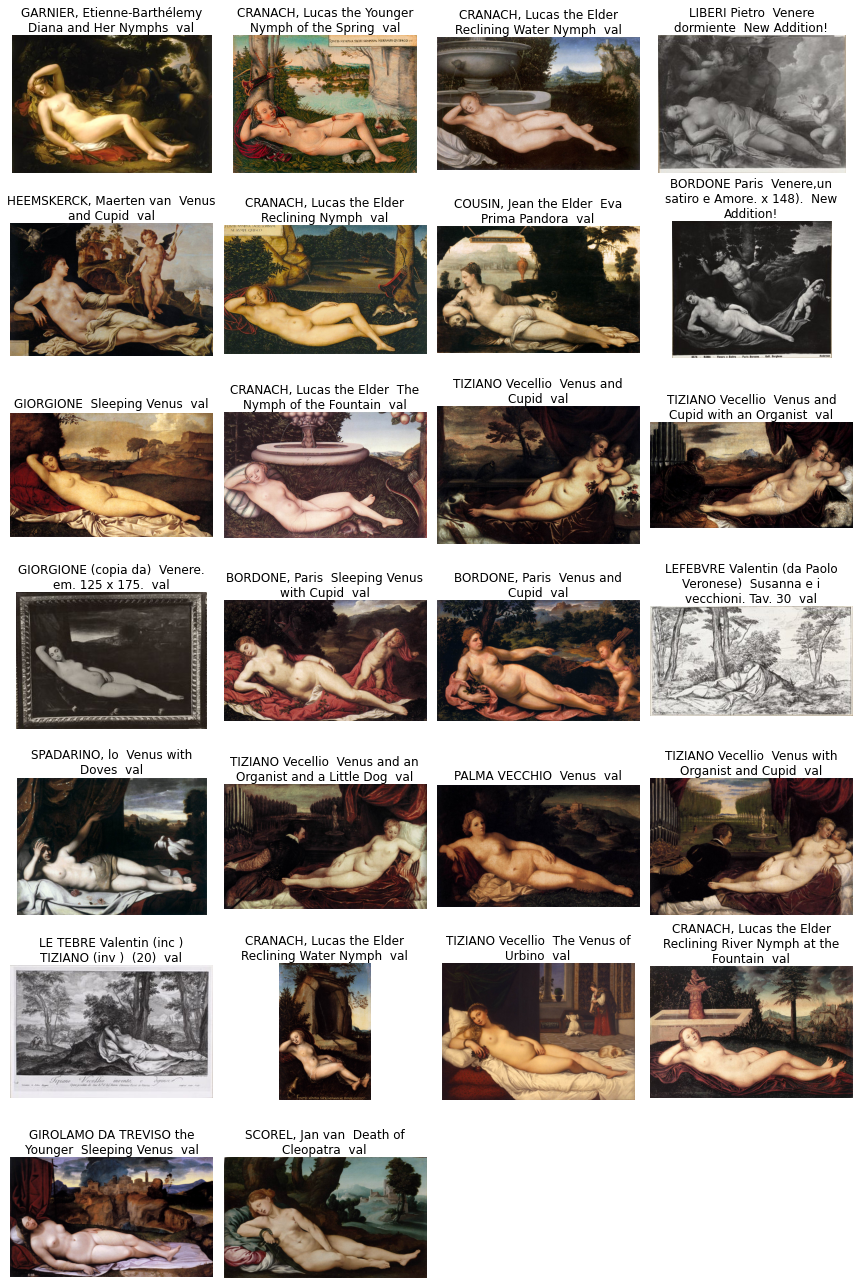

In [59]:
show_clusters(2, morpho, uid2path, '../../Figures/cluster_morpho_', '')

In [60]:
with open(data_dir + 'uid2path.pkl', 'rb') as infile:
    uid2path = pickle.load(infile)

cluster_file = '01-06-2022/clusters_optics_0.13_01-06-2022_19.pkl'

with open(data_dir + cluster_file , 'rb') as infile:
        cluster_df = pickle.load(infile)

metadata = pd.read_csv(data_dir + 'data_sample.csv')

In [61]:
data1 = metadata.drop(columns=['index', 'cluster', 'path', ]).merge(cluster_df, left_on='uid', right_on='uid')#.merge(morpho[['img1', 'annotated']], left_on='uid', right_on='img1')
data1.columns#'annotated', 'img1'

Index(['uid', 'uid_connection', 'AuthorOriginal', 'Description', 'Author',
       'AuthorBirth', 'BeginDate', 'ImageURL', 'City', 'Country',
       'AuthorBirthCity', 'AuthorDeathCity', 'Drawer', 'Type', 'img1', 'img2',
       'type', 'annotated', 'cluster_file', 'set', 'index', 'cluster', 'path',
       'cluster_size'],
      dtype='object')

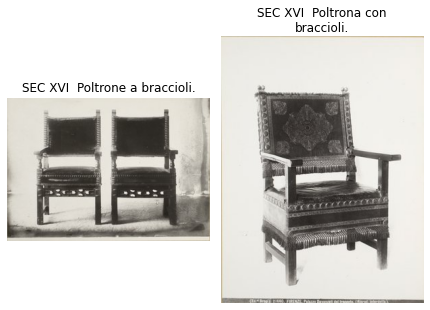

In [74]:
show_clusters(721, data1, uid2path, '../../Figures/cluster_optics_', '')

In [5]:
import random
samples = random.sample(range(1, 700), 5)

In [ ]:
for s in samples:
    show_clusters(s, data1, uid2path, '../../Figures/cluster_optics_', '')

In [75]:
cluster_file = '01-06-2022/clusters_mix_2000_01-06-2022_19.pkl'

with open(data_dir + cluster_file , 'rb') as infile:
        cluster_df = pickle.load(infile)

data = metadata.drop(columns=['index', 'cluster', 'path',]).merge(cluster_df, left_on='uid', right_on='uid')

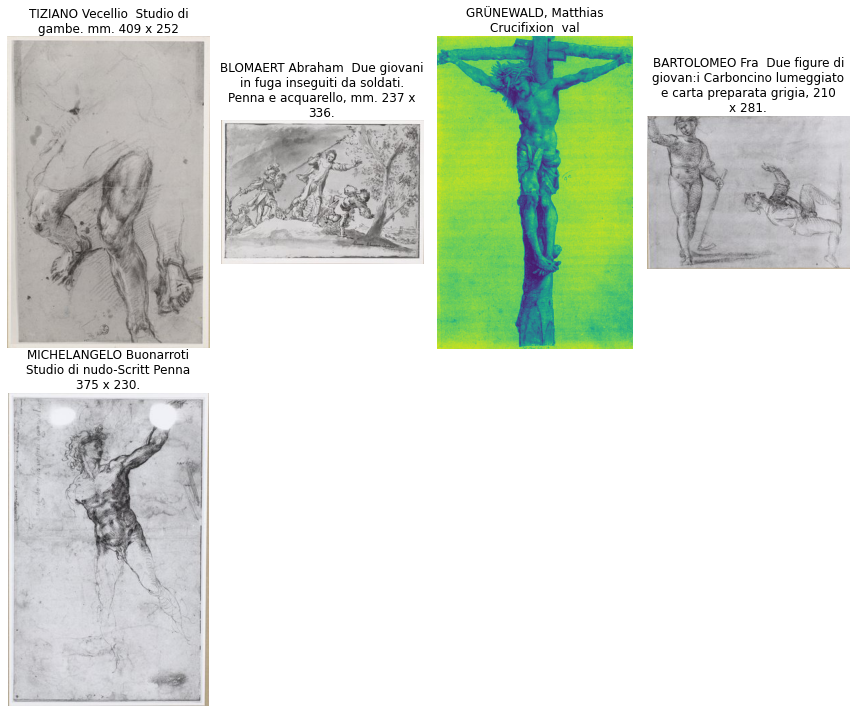

In [81]:
show_clusters(312, data, uid2path, '../../Figures/cluster_kmeans_', '')

In [ ]:
for s in samples:
    show_clusters(s, data, uid2path, '../../Figures/cluster_kmeans_', '')

In [84]:
metadata[metadata['AuthorOriginal'].str.contains('CARAVAGGIO')][metadata['Description'].str.contains('Paolo')]['ImageURL'].values

C:\Users\ludov\AppData\Local\Temp/ipykernel_28456/4156753544.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metadata[metadata['AuthorOriginal'].str.contains('CARAVAGGIO')][metadata['Description'].str.contains('Paolo')]['ImageURL'].values


array([], dtype=object)

In [20]:
from textwrap import wrap

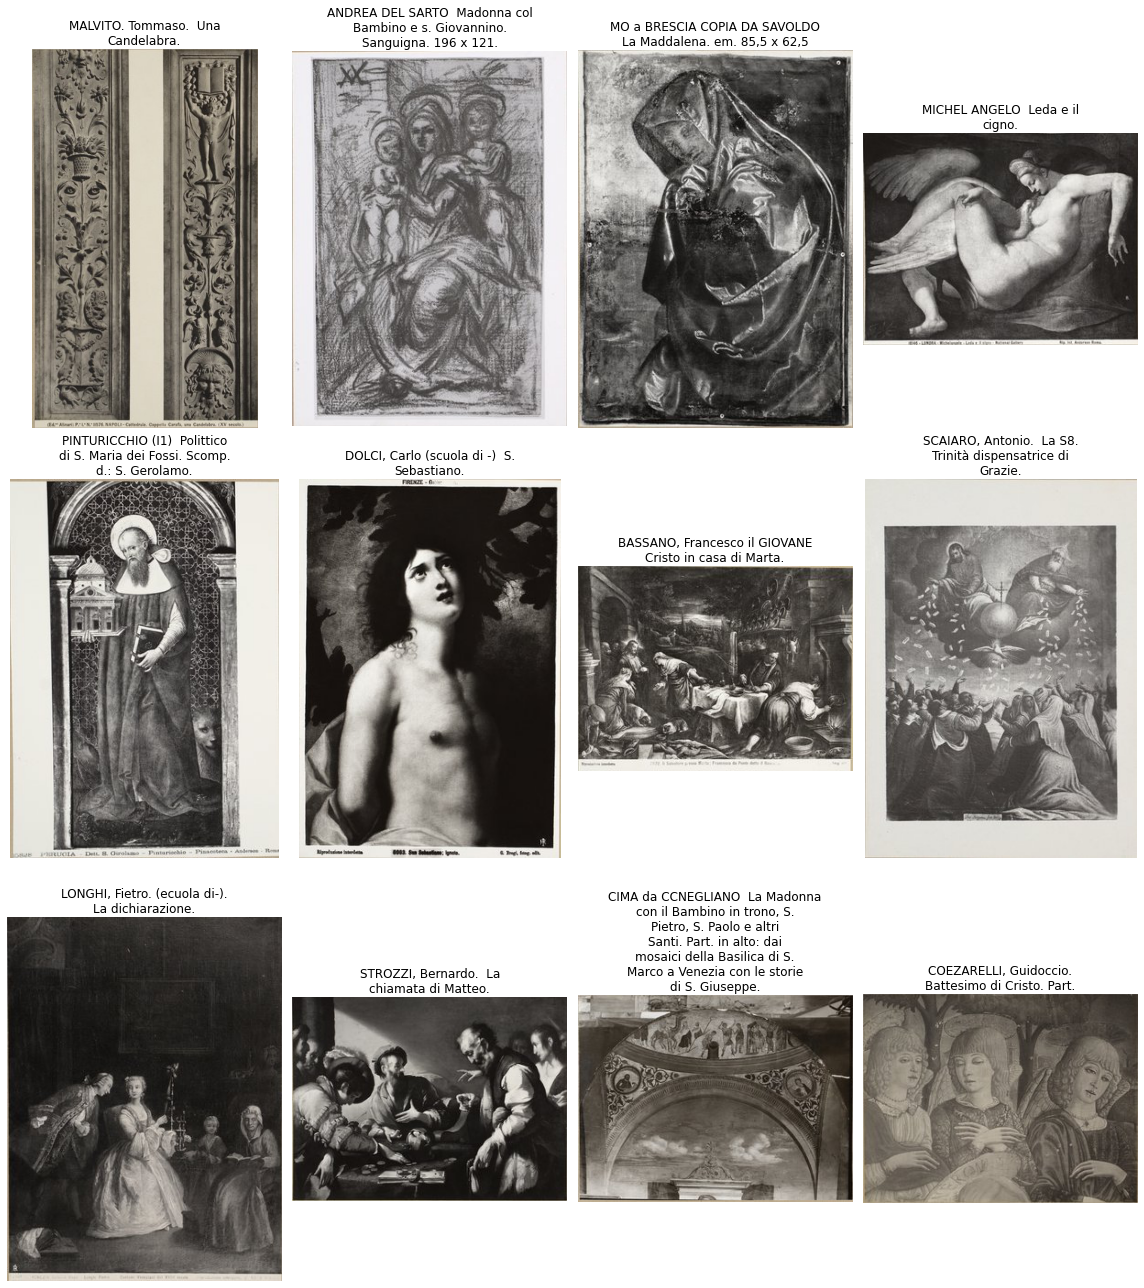

In [34]:
# sample data

sample = metadata[metadata['ImageURL'].str.contains('cini')].sample(12)
f, axarr = plt.subplots(3,4, figsize=(16,3 * 6))
axarr = axarr.flatten()
    

for i,row in sample.reset_index().iterrows():
    info = str(row["AuthorOriginal"]) + '\n ' + str(row["Description"])
    axarr[i].set_title("\n".join(wrap(info, 30)), wrap=True)
    image = requests.get(get_drawer(pd.DataFrame(row), catch(row['uid'], uid2path)))
    try:
        axarr[i].axis(False)
        axarr[i].set_aspect("equal")
        axarr[i].imshow(Image.open(BytesIO(image.content))) #replica_dir + 
    except Exception as e:
        print(get_drawer(pd.DataFrame(row), catch(row['uid'], uid2path)))

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('../../Figures/sample_cini.jpg')
plt.show()
    